In [1]:
import sys
import os
sys.path.append('../../')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import mdlcstat_adwin1
from functools import partial
%matplotlib inline
import pandas as pd
import datetime as dt
from copy import deepcopy

In [2]:
def preprocessing(ctr):#prepare data
    """
    Return a dataframe that contains date and logarithm of cumulative cases in a country.
    
    parameters:
        ctr: country name
    
    returns:
        dataframe with date and logarithm of cumulative cases
    """
    df=pd.read_csv('../../data/covid_data.csv')
    df=df[df["countriesAndTerritories"]==ctr][["dateRep", "cases"]]
    df["dateRep"]=pd.to_datetime(df["dateRep"], format="%d/%m/%Y")
    df=df.sort_values("dateRep").reset_index(drop=True)
    df.columns=["date", ctr]

    df[ctr]=df[ctr].cumsum()
    df=df[df[ctr]>0] 
    df=df.reset_index(drop=True)
    df[ctr]=np.log(df[ctr])

    deadline=pd.to_datetime("2020-4-30")
    df=df[df["date"]<=deadline].reset_index(drop=True)
        
    return df

In [3]:
def calculate_alpha(params):# adjust alpha
    """
    Calculate upper-bounds of hypothesis testings given by 1st and 2nd from data.
    
    parameters:
        params: hyperparameters for calculating LNML of Gaussian
    
    returns:
        alpha_1, alpha_2
    """
    country="Japan"
    df=preprocessing(country)
    events=[pd.to_datetime('2020/2/27')]
    lnml_gaussian=partial(mdlcstat_adwin1.lnml_gaussian, sigma_given=params['sigma_given']) 
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=lnml_gaussian,d=2,alpha=1,delta=0.05,how_to_drop='all', preprocess=True)

    ret_window, cut, mdl_0, mdl_1, mdl_2, alarm_0_p, alarm_0_m, alarm_1, alarm_2 = batch_adwin1.decision_function(np.array(df[country]))
    
    event_at=len(df[df['date']<events[0]])
    dif_1=0
    dif_2=0
    
    if np.isnan(mdl_1[event_at])==False:
        dif_1=0
    else:
        abs_dif=1
        while True:
            stat_p=mdl_1[event_at+abs_dif]
            stat_m=mdl_1[event_at-abs_dif]
            
            if np.isnan(stat_p)==True and np.isnan(stat_m)==True:
                abs_dif+=1
                continue
            elif np.isnan(stat_p)==False and np.isnan(stat_m)==False:
                if stat_p>stat_m:
                    dif_1=abs_dif
                    break
                else:
                    dif_1=-abs_dif
                    break
            else:
                if np.isnan(stat_p)==False:
                    dif_1=abs_dif
                    break
                else:
                    dif_1=-abs_dif
                    break

    if np.isnan(mdl_2[event_at])==False:
        dif_2=0
    else:
        abs_dif=1
        while True:
            stat_p=mdl_2[event_at+abs_dif]
            stat_m=mdl_2[event_at-abs_dif]
            
            if np.isnan(stat_p)==True and np.isnan(stat_m)==True:#どっちもnan
                abs_dif+=1
                continue
            elif np.isnan(stat_p)==False and np.isnan(stat_m)==False:
                if stat_p>stat_m:
                    dif_2=abs_dif
                    break
                else:
                    dif_2=-abs_dif
                    break
            else:
                if np.isnan(stat_p)==False:
                    dif_2=abs_dif
                    break
                else:
                    dif_2=-abs_dif
                    break
                    
    if ret_window[event_at+dif_1]==0:
        win_1=ret_window[event_at+dif_1-1]+1
    else:
        win_1=ret_window[event_at+dif_1]
        
    if ret_window[event_at+dif_2]==0:
        win_2=ret_window[event_at+dif_2-1]+1
    else:
        win_2=ret_window[event_at+dif_2]
        
    alpha_1=np.exp(2*np.log(win_1/2)-mdl_1[event_at])
    alpha_2=np.exp(2*np.log(win_2/2)-mdl_2[event_at]/2)    
    
    # if alpha exceeds 1, set them 0.99.
    if alpha_1>1:
        alpha_1=0.99
    if alpha_2>1:
        alpha_2=0.99
    
    return alpha_1, alpha_2


In [4]:
def country_graph(country, events, params):
    """
    Plot a graphs for each country.
    parameters:
        country: country name
        events: date of events for enforcement of social distancing
        params: hyperparameters for calculating statistics
    """
    if country == "Korea, South":
        ctr="South_Korea"
        printctr="South Korea"
    elif country == "US":
        ctr="United_States_of_America"
        printctr="United States of America"
    elif country=="Saudi Arabia":
        ctr="Saudi_Arabia"
        printctr="Saudi Arabia"
    elif country=="United Arab Emirates":
        ctr="United_Arab_Emirates"
        printctr="United Arab Emirates"
    elif country=="United Kingdom":
        ctr="United_Kingdom"
        printctr="United Kingdom"
    else:
        ctr=country
        printctr=country
    
    #data preprocessing
    df=preprocessing(ctr)
            
    alpha_1=params["alpha_1"]
    alpha_2=params["alpha_2"]
   
    lnml_gaussian=partial(mdlcstat_adwin1.lnml_gaussian, sigma_given=params['sigma_given']) 
    #calculate statistics with tuned alpha
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=lnml_gaussian,d=2,alpha=alpha_1,delta=0.05,how_to_drop='all', preprocess=True)
    ret_window, cut, mdl_0, mdl_1, _, alarm_0_p, alarm_0_m, alarm_1, _ =batch_adwin1.decision_function(np.array(df[ctr]))
    batch_adwin1 = mdlcstat_adwin1.batch(lossfunc=lnml_gaussian,d=2,alpha=alpha_2,delta=0.05,how_to_drop='all', preprocess=True)
    _, _, _, _, mdl_2, _, _, _, alarm_2 =batch_adwin1.decision_function(np.array(df[ctr]))    

    alarm_0=np.r_[alarm_0_p,alarm_0_m]
    alarm_0=np.sort(alarm_0)
    
    cut=cut[np.where(cut!=-1)]
    for i in range(len(cut)):
        if i!=0:
            cut[i]+=alarm_0[i-1]+1

    alarm_0_index=deepcopy(alarm_0)
    alarm_1_index=deepcopy(alarm_1)
    alarm_2_index=deepcopy(alarm_2)
    
    alarm_0=df['date'][alarm_0].reset_index(drop=True)
    alarm_0_p=df['date'][alarm_0_p].reset_index(drop=True)  
    alarm_0_m=df['date'][alarm_0_m].reset_index(drop=True)
    alarm_1=df['date'][alarm_1].reset_index(drop=True)
    alarm_2=df['date'][alarm_2].reset_index(drop=True)
    cut=df['date'][cut].reset_index(drop=True)
    
    print('date for alarms of 0th D-MDL')
    print(alarm_0)
    print('cutpoint')
    print(cut)
    
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)

    #plot data
    #0th D-MDL
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], mdl_0/np.nanmax(mdl_0)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('0th D-MDL change score')

    ##for marking changes 
    for p_index in alarm_0_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_0[p_index]/np.nanmax(mdl_0), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    plt.ylim(0,1.1)
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.tight_layout()
    plt.savefig('../../figs/'+country+'_0_score.eps')
    
    #1st D-MDL
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], mdl_1/np.nanmax(mdl_1)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('1st D-MDL change score')

    ##for marking signs of changes 
    for p_index in alarm_1_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_1[p_index]/np.nanmax(mdl_1), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    plt.ylim(0,1.1)
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.tight_layout()
    plt.savefig('../../figs/'+country+'_1_score.eps')
     
    #2nd D-MDL
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], mdl_2/np.nanmax(mdl_2)) ## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('2nd D-MDL change score')

    ##for marking signs of changes 
    for p_index in alarm_2_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=mdl_2[p_index]/np.nanmax(mdl_2), color='r', linestyle='--')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    plt.ylim(0,1.1)
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.tight_layout()
    plt.savefig('../../figs/'+country+'_2_score.eps')
    
    #cases
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df['date'], np.exp(df[ctr]))## dates in datetime format and change scores
    plt.gcf().autofmt_xdate()
    plt.yscale('log')
    plt.title(printctr)
    plt.ylabel('Cumulative cases')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=max(np.exp(df[ctr]))*1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    #plt.ylim(0,max(df[country])*1.1)
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.tight_layout()
    plt.savefig('../../figs/'+country+'_case.eps')

    df_window=pd.DataFrame({'date': df['date'].values, 'window': ret_window})
    df_supplementary=pd.DataFrame({'date': df['date'][alarm_0_index].values, 'window': ret_window[alarm_0_index-1]+1})
    df_concat=pd.concat([df_window, df_supplementary], axis=0)
    df_concat=df_concat.sort_values(['date','window'], ascending=[False, True])
    
    #window size
    plt.clf()
    plt.figure(figsize=(28,10))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(df_concat['date'], df_concat['window'])
    plt.gcf().autofmt_xdate()
    plt.title(printctr)
    plt.ylabel('Window size')

    ##for marking changes 
    for p_index in alarm_0_index:
        plt.vlines(df['date'][p_index], ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='r', linestyle='-')

    ## for making social distancing event   
    plt.vlines(events, ymin=0, ymax=max(40, np.nanmax(ret_window)*1.1)*1.1, color='black', linestyle='-',linewidth=2)
    plt.text(events, 0.8, 'Social distancing', color='black')

    plt.ylim(0,max(40, np.nanmax(ret_window)*1.1))
    plt.rc('font', size=36) 
    plt.rc('xtick', labelsize=36)    
    plt.rc('ytick', labelsize=36)
    plt.tight_layout()
    plt.savefig('../../figs/'+country+'_window_size.eps')


In [5]:
countries=["Austria", "Belarus", "Belgium", "Brazil", "Canada", "Chile", "China", "Ecuador",
          "France", "Germany", "India", "Indonesia", "Iran",  "Ireland", "Israel", "Italy", "Japan", "Mexico",
          "Netherlands", "Pakistan", "Peru", "Poland", "Portugal", "Qatar", "Romania", "Russia",
          "Saudi Arabia", "Singapore", "Korea, South", "Spain", "Sweden", "Switzerland", "Turkey",
          "United Arab Emirates", "Ukraine", "United Kingdom", "US"]

events_Austria=[pd.to_datetime('2020/3/16')]
events_Belarus=[pd.to_datetime('2020/4/9')]
events_Belgium=[pd.to_datetime('2020/3/18')]
events_Brazil=[pd.to_datetime('2020/3/24')]
events_Canada=[pd.to_datetime('2020/3/17')]
events_Chile=[pd.to_datetime('2020/3/26')]
events_China=[pd.to_datetime('2020/1/23')]
events_Ecuador=[pd.to_datetime('2020/3/16')]
events_France=[pd.to_datetime('2020/3/17')]
events_Germany=[pd.to_datetime('2020/3/16')]
events_India=[pd.to_datetime('2020/3/25')]
events_Indonesia=[pd.to_datetime('2020/4/6')]
events_Iran=[pd.to_datetime('2020/3/24')]
events_Ireland=[pd.to_datetime('2020/3/12')]
events_Israel=[pd.to_datetime('2020/3/15')]
events_Italy=[pd.to_datetime('2020/3/9')]
events_Japan=[pd.to_datetime('2020/4/7')]
events_Mexico=[pd.to_datetime('2020/3/23')]
events_Netherlands=[pd.to_datetime('2020/3/15')]
events_Pakistan=[pd.to_datetime('2020/3/24')]
events_Peru=[pd.to_datetime('2020/3/16')]
events_Poland=[pd.to_datetime('2020/3/24')]
events_Portugal=[pd.to_datetime('2020/3/19')]
events_Qatar=[pd.to_datetime('2020/3/23')]
events_Romania=[pd.to_datetime('2020/3/23')]
events_Russia=[pd.to_datetime('2020/3/30')]
events_Saudi_Arabia=[pd.to_datetime('2020/3/24')]
events_Singapore=[pd.to_datetime('2020/4/7')]
events_South_Korea=[pd.to_datetime('2020/2/25')]
events_Spain=[pd.to_datetime('2020/3/13')]
events_Sweden=[pd.to_datetime('2020/3/24')]
events_Switzerland=[pd.to_datetime('2020/3/16')]
events_Turkey=[pd.to_datetime('2020/3/21')]
events_United_Arab_Emirates=[pd.to_datetime('2020/3/31')]
events_Ukraine=[pd.to_datetime('2020/3/25')]
events_United_Kingdom=[pd.to_datetime('2020/3/24')]
events_United_States=[pd.to_datetime('2020/3/19')]

events_all={
    "Austria": events_Austria, "Belarus": events_Belarus, "Belgium": events_Belgium, "Brazil": events_Brazil, 
    "Canada": events_Canada, "Chile": events_Chile, "China": events_China, "Ecuador": events_Ecuador,
    "France": events_France, "Germany": events_Germany, "India": events_India, "Indonesia":events_Indonesia, "Iran": events_Iran, 
    "Ireland": events_Ireland, "Israel": events_Israel, "Italy": events_Italy, "Japan": events_Japan,
    "Mexico": events_Mexico, "Netherlands": events_Netherlands, "Pakistan": events_Pakistan, "Peru": events_Peru,
    "Poland": events_Poland, "Portugal": events_Portugal, "Qatar": events_Qatar, "Romania": events_Romania, 
    "Russia": events_Austria, "Saudi Arabia": events_Saudi_Arabia, "Singapore": events_Singapore, "Korea, South": events_South_Korea, 
    "Spain": events_Spain, "Sweden": events_Sweden, "Switzerland": events_Switzerland, "Turkey": events_Turkey,
    "United Arab Emirates": events_United_Arab_Emirates, "Ukraine":events_Ukraine, "United Kingdom": events_United_Kingdom, "US": events_United_States
}    

92.33199744142047
247.24830664512976
0.99
0.99
Austria
date for alarms of 0th D-MDL
0   2020-04-11
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-27
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Belarus
date for alarms of 0th D-MDL
Series([], Name: date, dtype: datetime64[ns])
cutpoint
Series([], Name: date, dtype: datetime64[ns])
Belgium
date for alarms of 0th D-MDL
0   2020-03-05
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-02
Name: date, dtype: datetime64[ns]
Brazil
date for alarms of 0th D-MDL
0   2020-04-18
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-28
Name: date, dtype: datetime64[ns]


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canada
date for alarms of 0th D-MDL
0   2020-03-29
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-08
Name: date, dtype: datetime64[ns]
Chile
date for alarms of 0th D-MDL
0   2020-04-17
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-23
Name: date, dtype: datetime64[ns]
China
date for alarms of 0th D-MDL
0   2020-03-08
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-15
Name: date, dtype: datetime64[ns]
Ecuador
date for alarms of 0th D-MDL
0   2020-04-20
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-26
Name: date, dtype: datetime64[ns]
France
date for alarms of 0th D-MDL
0   2020-03-08
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-28
Name: date, dtype: datetime64[ns]
Germany
date for alarms of 0th D-MDL
0   2020-03-17
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-02-27
Name: date, dtype: datetime64[ns]
India
date for alarms of 0th D-MDL
0   2020-03-18
Name: date, dtype: datetime64[ns]
cutpoint
0   2020-03-04
Name: date, dtype: datetime64[ns]


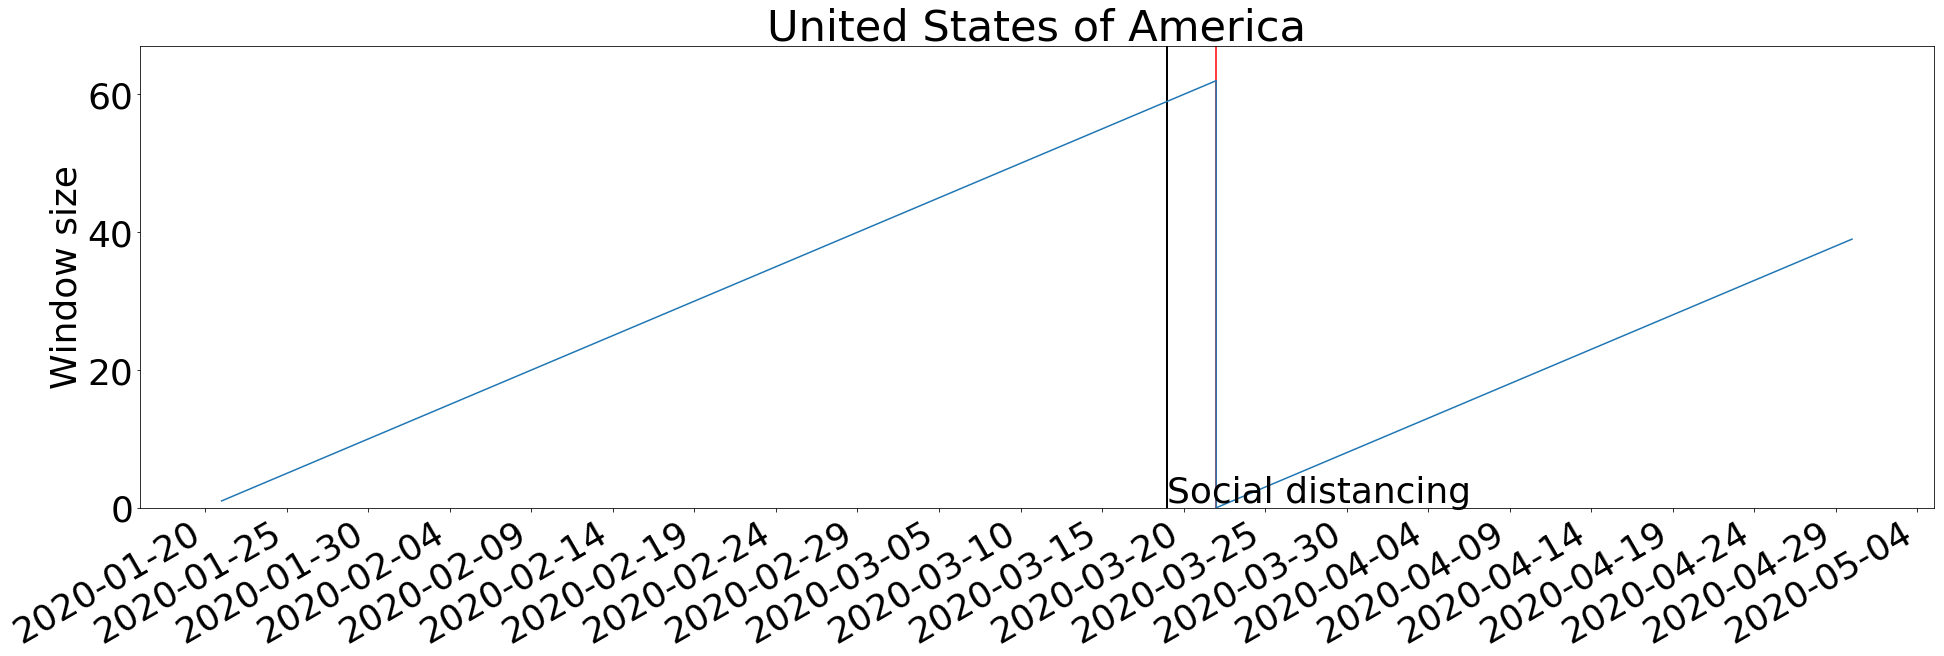

In [6]:
sigma_given=0.4 #hyperparameter for LNML of Gaussian
alpha_1, alpha_2 = calculate_alpha({"sigma_given": sigma_given}) # upper-bounds for 1st and 2nd D-MDL

print(alpha_1)
print(alpha_2)

parameters={"sigma_given": sigma_given, "alpha_1": alpha_1, "alpha_2": alpha_2}

os.makedirs("../../figs", exist_ok=True)

for country in countries:
    events=events_all[country]
    print(country)
    country_graph(country, events, parameters)